In [ ]:
import nltk
from nltk.stem.porter import *
import pickle
import os,sys
from io import open
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from keras import backend as K
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed
from keras.layers import Embedding, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import brown


!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

train = open("train.txt", "r")
test = open("test.txt", "r")
train_lines = train.readlines()
test_lines = test.readlines()

train_sentences  = [ [] for _ in range(8936) ]
train_pos = [ [] for _ in range(8936) ]
train_chunks = [ [] for _ in range(8936) ]
j = 0
for line in train_lines:
  if line == '\n':
    j = j+1
  else:
    train_sentences[j].append(line.split()[0])
    train_chunks[j].append(line.split()[2].split('-')[0])

test_sentences  = [ [] for _ in range(2012) ]
test_chunks = [ [] for _ in range(2012) ]
j = 0
for line in test_lines:
  if line == '\n':
    j = j+1
  else:
    test_sentences[j].append(line.split()[0])
    test_chunks[j].append(line.split()[2].split('-')[0])



--2020-10-03 19:41:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-03 19:41:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-03 19:41:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
import nltk
from nltk.stem.porter import *
import pickle
import os,sys
from io import open
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from keras import backend as K
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed
from keras.layers import Embedding, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import brown

glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

train = open("train.txt", "r")
test = open("test.txt", "r")
train_lines = train.readlines()
test_lines = test.readlines()

train_sentences  = [ [] for _ in range(8936) ]
train_pos = [ [] for _ in range(8936) ]
train_chunks = [ [] for _ in range(8936) ]
j = 0
for line in train_lines:
  if line == '\n':
    j = j+1
  else:
    train_sentences[j].append(line.split()[0])
    train_chunks[j].append(line.split()[2].split('-')[0])

test_sentences  = [ [] for _ in range(2012) ]
test_chunks = [ [] for _ in range(2012) ]
j = 0
for line in test_lines:
  if line == '\n':
    j = j+1
  else:
    test_sentences[j].append(line.split()[0])
    test_chunks[j].append(line.split()[2].split('-')[0])

Found 400000 word vectors.


In [ ]:
train_pos = [ [] for _ in range(8936) ]
test_pos = [ [] for _ in range(2012) ]
j = 0
for line in train_lines:
  if line == '\n':
    j = j+1
  else:
    train_pos[j].append(line.split()[1])
j = 0
for line in test_lines:
  if line == '\n':
    j = j+1
  else:
    test_pos[j].append(line.split()[1])




In [ ]:
test_sentences  = [ [] for _ in range(2012) ]
test_chunks = [ [] for _ in range(2012) ]
j = 0
for line in test_lines:
  if line == '\n':
    j = j+1
  else:
    test_sentences[j].append(line.split()[0])
    test_chunks[j].append(line.split()[2].split('-')[0])

In [ ]:
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

def one_hot_encoding(tag_sents, n_tags):
    tag_one_hot_sent = []
    for tag_sent in tag_sents:
        tags_one_hot = []
        for tag in tag_sent:
            tags_one_hot.append(np.zeros(n_tags))
            tags_one_hot[-1][tag] = 1.0
        tag_one_hot_sent.append(tags_one_hot)
    return np.array(tag_one_hot_sent)

def logits_to_tags(tag_sentences, index):
    tag_sequences = []
    for tag_sentence in tag_sentences:
        tag_sequence = []
        for tag in tag_sentence:
            # if index[np.argmax(tag)] == "-PAD-":
            #     break
            # else:
                tag_sequence.append(index[np.argmax(tag)])
        tag_sequences.append(np.array(tag_sequence))
    return tag_sequences

In [ ]:
MAX_LENGTH = len(max(train_sentences, key=len))


chunk_list=['-PAD-','B','I','O']

In [ ]:
embeddings_index = {} #initialize dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Bidirectional, TimeDistributed
from keras.optimizers import Adagrad

words, chunks = set([]), set([])
tags = set([])
    #creating sets of words and tags 
for sentence in train_sentences:
  for word in sentence:
    words.add(word.lower())
 
for sentence in train_chunks:
  for chunk in sentence:
    chunks.add(chunk)

for tag_sent in train_pos:
        for tag in tag_sent:
            tags.add(tag)


    #bulding vocabulary of words and tags 
word2index = {word: i + 2 for i, word in enumerate(list(words))}
word2index['-PAD-'] = 0  # 0 is assigned for padding
word2index['-OOV-'] = 1  # 1 is assigned for unknown words
chunk2index = {chunk: i + 1 for i, chunk in enumerate(list(chunks))}
chunk2index['-PAD-'] = 0  # 0 is assigned for padding
tag2index = {tag: i + 1 for i, tag in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # 0 is assigned for padding

    #Tokenising words and  by their indexes in vocabulary
train_sentences_X, test_sentences_X, train_chunks_y, test_chunks_y = [], [], [], []
train_pos_X, test_pos_X = [], []
 
for sentence in train_sentences:
  sent_int = []
  for word in sentence:
    try:
      sent_int.append(word2index[word.lower()])
    except KeyError:
      sent_int.append(word2index['-OOV-'])
  train_sentences_X.append(sent_int)
 
for sentence in test_sentences:
  sent_int = []
  for word in sentence:
    try:
      sent_int.append(word2index[word.lower()])
    except KeyError:
      sent_int.append(word2index['-OOV-'])
  test_sentences_X.append(sent_int)
 
for sent_chunks in train_chunks:
  train_chunks_y.append([chunk2index[chunk] for chunk in sent_chunks])
 
for sent_chunks in test_chunks:
  test_chunks_y.append([chunk2index[chunk] for chunk in sent_chunks])

for sent_tags in train_pos:
  train_pos_X.append([tag2index[tag] for tag in sent_tags])
 
for sent_tags in test_pos:
  test_pos_X.append([tag2index[tag] for tag in sent_tags])  

    #Add padding to sentences
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_chunks_y = pad_sequences(train_chunks_y, maxlen=MAX_LENGTH, padding='post')
test_chunks_y = pad_sequences(test_chunks_y, maxlen=MAX_LENGTH, padding='post')
train_pos_X = pad_sequences(train_pos_X, maxlen=MAX_LENGTH, padding='post')
test_pos_X = pad_sequences(test_pos_X, maxlen=MAX_LENGTH, padding='post')

    #Building the Embedding Layer 
embedding_dim = 300

embedding_matrix = np.zeros((len(word2index), embedding_dim))
for word, i in word2index.items():
  embedding_vector = embeddings_index.get(word)
  if i < len(word2index):
    if embedding_vector is not None:
                # Words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
    
# Building the BiLSTM model without POS tag
# model = Sequential()
# model.add(InputLayer(input_shape=MAX_LENGTH,))
# model.add(Embedding(len(word2index), 300, weights=[embedding_matrix],trainable=False))
# model.add(Bidirectional(LSTM(256, return_sequences=True)))
# model.add(TimeDistributed(Dense(len(chunk2index))))
# model.add(Activation('softmax'))

#Building the BiLSTM model with POS tag
word_input = Input(
    shape=(MAX_LENGTH,), name="word"
)  # text
tags_input = Input(
    shape=(MAX_LENGTH,), name="tags"
)  # tags

tag_features = Embedding(len(tag2index), 128)(tags_input)

word_features = Embedding(len(word2index), 300, weights=[embedding_matrix],trainable=False)(word_input)
word_lstm = Bidirectional(LSTM(256, return_sequences=True))(word_features)
tag_lstm = Bidirectional(LSTM(256, return_sequences=True))(tag_features)

x = concatenate([word_lstm, tag_lstm])
o = Dense(len(chunk2index))(x)
output = Activation('softmax')(o)

model = Model(inputs=[word_input, tags_input],outputs= output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001),
                  metrics=['accuracy', ignore_class_accuracy(0)])
model.summary()
one_hot_train_chuns_y = one_hot_encoding(train_chunks_y, len(chunk2index))
    

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word (InputLayer)               [(None, 78)]         0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 78)]         0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 78, 300)      5178000     word[0][0]                       
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 78, 128)      5760        tags[0][0]                       
______________________________________________________________________________________

In [ ]:
#Training the model

# model.fit({"word":train_sentences_X, "tags": train_pos_X}, one_hot_encoding(train_chunks_y, len(chunk2index)), 
#               batch_size=128, epochs= 13, validation_split=0.2)  #with POS tag

#without POS tag
model.fit(train_sentences_X, one_hot_encoding(train_chunks_y, len(chunk2index)), batch_size=128, epochs= 20, validation_split=0.2)



Epoch 1/20
56/56 [==============================] - 3s 49ms/step - loss: 0.2841 - accuracy: 0.8984 - ignore_accuracy: 0.7164 - val_loss: 0.1321 - val_accuracy: 0.9447 - val_ignore_accuracy: 0.8189
Epoch 2/20
56/56 [==============================] - 2s 35ms/step - loss: 0.1131 - accuracy: 0.9547 - ignore_accuracy: 0.8514 - val_loss: 0.1039 - val_accuracy: 0.9592 - val_ignore_accuracy: 0.8663
Epoch 3/20
56/56 [==============================] - 2s 35ms/step - loss: 0.0921 - accuracy: 0.9653 - ignore_accuracy: 0.8860 - val_loss: 0.0895 - val_accuracy: 0.9667 - val_ignore_accuracy: 0.8909
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 0.0782 - accuracy: 0.9710 - ignore_accuracy: 0.9048 - val_loss: 0.0787 - val_accuracy: 0.9702 - val_ignore_accuracy: 0.9024
Epoch 5/20
56/56 [==============================] - 2s 35ms/step - loss: 0.0679 - accuracy: 0.9753 - ignore_accuracy: 0.9189 - val_loss: 0.0705 - val_accuracy: 0.9735 - val_ignore_accuracy: 0.9133
Epoch 6/20
56/5

In [ ]:
#scores = model.evaluate({"word":test_sentences_X, "tags": test_pos_X}, one_hot_encoding(test_chunks_y, len(chunk2index)))
scores = model.evaluate(test_sentences_X, one_hot_encoding(test_chunks_y, len(chunk2index)))
scores[2]*100

63/63 [==============================] - 1s 9ms/step - loss: 0.0594 - accuracy: 0.9818 - ignore_accuracy: 0.9399


93.9885139465332

In [ ]:
# predictions = model.predict({"word":test_sentences_X, "tags": test_pos_X})
predictions = model.predict(test_sentences_X)
pred_sequence = logits_to_tags(predictions, {i: t for t, i in chunk2index.items()})


conf_mat_df = pd.DataFrame(columns=chunk_list, index=chunk_list)
conf_mat_df = conf_mat_df.fillna(0)

for sen_num in range(len(test_chunks)):
  for i,chunk in enumerate(test_chunks[sen_num]):
    conf_mat_df[chunk][pred_sequence[sen_num][i]] +=1


In [ ]:
conf_mat_df

,-PAD-,B,I,O
-PAD-,0,6,4,5
B,0,22834,1203,151
I,0,908,15836,180
O,0,104,302,5844


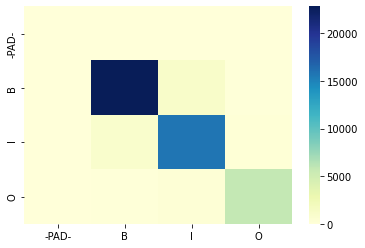

In [ ]:
import seaborn as sns

sns.heatmap(conf_mat_df, cmap="YlGnBu")


In [ ]:
recall_B = conf_mat_df['B']['B']/(conf_mat_df['B']['B']+conf_mat_df['B']['I'])
print("recall_B:" +  str(recall_B))
recall_I = conf_mat_df['I']['I']/(conf_mat_df['I']['B']+conf_mat_df['I']['I'])
print("recall_I:" + str(recall_I))

total_recall = (conf_mat_df['B']['B'] + conf_mat_df['I']['I'])/(conf_mat_df['B']['B']+conf_mat_df['B']['I']+conf_mat_df['I']['B']+conf_mat_df['I']['I'])
print("recall:" +  str(total_recall))

recall_B:0.9617555387077753
recall_I:0.929397265097717
recall:0.9482356979966161


In [ ]:
precision_B = conf_mat_df['B']['B']/(conf_mat_df['B']['B']+conf_mat_df['I']['B'])
print("precision_B:" +  str(precision_B))
precision_I = conf_mat_df['I']['I']/(conf_mat_df['B']['I']+conf_mat_df['I']['I'])
print("precision_I:" + str(precision_I))

total_precision = (conf_mat_df['B']['B'] + conf_mat_df['I']['I'])/(conf_mat_df['B']['B']+conf_mat_df['B']['I']+conf_mat_df['I']['B']+conf_mat_df['I']['I'])
print("precision:" +  str(total_precision))

precision_B:0.9499521570911511
precision_I:0.9457716196846632
precision:0.9482356979966161


In [ ]:
f1score_B = 2*precision_B*recall_B/ (recall_B +precision_B)
f1score_I = 2*precision_I*recall_I/ (recall_I +precision_I)
print("f1score B:" + str(f1score_B))
print("f1score I:" + str(f1score_I))

f1score B:0.9558174093220873
f1score I:0.937512950300447
